<a href="https://colab.research.google.com/github/Riaduddin/German_Credit_Data/blob/main/German_Credit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
german_data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/german_credit_data.csv')
german_data

,Status_of_existing,Duration_in_month,Credit_history,Purpose,Credit_amount,Savings_Account,Present_Employment,Installment_rate,Personal_status&_sex,Other_debtors,Present_residence,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits,Job,Number_of_people_being_liable_to_provide_maintence_for,Telephone,Foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201,2


Chi-square Test

In [3]:
import seaborn as sns
import scipy.stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency
col_list=list(german_data.columns)
col_list.remove('class')
for col in col_list:
  if german_data[col].dtype=='object':
    dataset_table=pd.crosstab(german_data[col],german_data['class'])
    observed_values=dataset_table.values
    val=chi2_contingency(dataset_table)
    expected_values=val[3]
    chi_square=sum([(o-e)**2./e for o,e in zip(observed_values,expected_values)])
    chi_square_statistic=chi_square[0]+chi_square[1]
    rows=len(german_data[col].value_counts())
    cols=len(german_data['class'].value_counts())
    ddof=(rows-1)*(cols-1)
    alpha=.05
    critical_value=scipy.stats.chi2.ppf(q=1-alpha,df=ddof)
    p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
    if (p_value>alpha) & (chi_square_statistic<critical_value):
      print('reject {}'.format(col))

reject Job
reject Telephone


In [4]:
df=german_data.drop(['Job','Telephone'],axis=1)

IV Value

In [5]:
def calculate_woe_iv(df,feature,target):
  lst=[]
  for i in range(df[feature].nunique()):
    val=list(df[feature].unique())[i]
    lst.append({
        'Value': val,
        'All':df[df[feature]==val].count()[feature],
        'Good':df[(df[feature]==val) & (df[target]==1)].count()[feature],
        'Bad':df[(df[feature]==val) & (df[target]==2)].count()[feature]
    })
  dset=pd.DataFrame(lst)
  dset['Distr_Good']=dset['Good']/dset['Good'].sum()
  dset['Distr_Bad']=dset['Bad']/dset['Bad'].sum()
  dset['Woe']=np.log(dset['Distr_Good']/dset['Distr_Bad'])
  dset=dset.replace({'Woe':{np.inf:0,-np.inf:0}})
  dset['IV']=(dset['Distr_Good']-dset['Distr_Bad'])*dset['Woe']
  iv=dset['IV'].sum()
  dset=dset.sort_values(by='Woe')
  return dset,iv

In [6]:
col_list=list(df.columns)
for col in col_list:
  if col=='class':
    continue
  elif df[col].dtype =='object':
    data,iv=calculate_woe_iv(df,col,'class')
    if iv <.1:
      print('reject {}'.format(col))

reject Present_Employment
reject Personal_status&_sex
reject Other_debtors
reject Other_installment_plans
reject Housing
reject Foreign_worker


In [7]:
new_data=df.drop(['Present_Employment','Personal_status&_sex','Other_debtors','Other_installment_plans','Housing','Foreign_worker'],axis=1)

In [8]:
col_list=[]
for col in new_data.columns:
  if ((new_data[col].dtype=='object') & (col !='class')):
    col_list.append(col)
df_2=pd.get_dummies(new_data[col_list],drop_first=True)
df_combined=pd.concat([new_data,df_2],axis=1)
df_combined.drop(columns=col_list,inplace=True)
df_combined=df_combined.astype('int')


In [9]:
df_combined['class']=df_combined['class']-1

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
col_list_1=[]
for col in df_combined.columns:
  if ((df_combined[col].dtype != 'object') & (col !='class')):
    col_list_1.append(col)
X=df_combined[col_list_1]
vif_data=pd.DataFrame()
vif_data['feature']=X.columns
vif_data['VIF']=[vif(X.values,i) for i in range(len(X.columns))]

vif_data

,feature,VIF
0,Credit_amount,2.921920
1,Status_of_existing_A12,2.092964
2,Status_of_existing_A13,1.239963
3,Status_of_existing_A14,2.762788
4,Credit_history_A31,1.316298
5,Credit_history_A32,4.379679
6,Credit_history_A33,1.718647
7,Credit_history_A34,2.930504
8,Purpose_A41,1.552389
9,Purpose_A410,1.106733


Removing columns which VIF value is greater than 5

In [11]:
#df_combined.drop('Age_in_years',axis=1,inplace=True)
#df_combined.drop('Number_of_people_being_liable_to_provide_maintence_for',axis=1,inplace=True)
#df_combined.drop('Installment_rate',axis=1,inplace=True)
#df_combined.drop('Number_of_existing_credits',axis=1,inplace=True)
#df_combined.drop('Present_residence',axis=1,inplace=True)
#df_combined.drop('Duration_in_month',axis=1,inplace=True)

In [28]:
print(len(df_combined.columns))

25


In [26]:
df=df_combined.drop('class',axis=1)
col=df.columns

In [29]:
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler()
X=pd.DataFrame(scaler.fit_transform(df_combined.drop('class',axis=1)),columns=col)
X

,Credit_amount,Status_of_existing_A12,Status_of_existing_A13,Status_of_existing_A14,Credit_history_A31,Credit_history_A32,Credit_history_A33,Credit_history_A34,Purpose_A41,Purpose_A410,Purpose_A42,Purpose_A43,Purpose_A44,Purpose_A45,Purpose_A46,Purpose_A48,Purpose_A49,Savings_Account_A62,Savings_Account_A63,Savings_Account_A64,Savings_Account_A65,Property_A122,Property_A123,Property_A124
0,0.050567,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.313690,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.101574,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.419941,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.254209,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.081765,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.198470,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
997,0.030483,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
998,0.087763,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,df_combined['class'],test_size=.2,random_state=42)

Selecting features using RFE which p-value is less than .05 & calculating c-statistic value

In [42]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
for i in range(8,20,1):
  Lg=LogisticRegression()
  rfe=RFE(Lg,i)
  rfe=rfe.fit(x_train,y_train)
  col_list=[]
  for i,col in zip(rfe.support_,x_train.columns):
    if i == True:
      col_list.append(col)
  x_train_rfe=sm.add_constant(x_train[col_list])
  log_reg=sm.Logit(y_train,x_train_rfe).fit()
  print(log_reg.summary())
  y_pred=pd.DataFrame(log_reg.predict(x_train_rfe))
  y_pred.columns=['Prob']
  both=pd.concat([y_train,y_pred],axis=1)
  zeros=both[both['class']==0]
  ones=both[both['class']==1]
  def df_crossjoin(df1,df2):
    df1=df1.copy()
    df2=df2.copy()
    df1.loc[:,'_tmpkey']=1
    df2.loc[:,'_tmpkey']=1
    res=pd.merge(df1,df2,on='_tmpkey')
    res.drop('_tmpkey',axis=1,inplace=True)
    #res.index=pd.MultiIndex.from_product((df1.index,df2.index))
    df1.drop('_tmpkey',axis=1,inplace=True)
    df2.drop('_tmpkey',axis=1,inplace=True)
    return res
  joined_data=df_crossjoin(ones,zeros)
  joined_data['concordant_pair']=0
  joined_data.loc[joined_data['Prob_x']>joined_data['Prob_y'],'concordant_pair']=1
  joined_data['discordant_pair']=0
  joined_data.loc[joined_data['Prob_x']<joined_data['Prob_y'],'discordant_pair']=1
  joined_data['tied_pair']=0
  joined_data.loc[joined_data['Prob_x']==joined_data['Prob_y'],'tied_pair']=1
  p_conc=(sum(joined_data['concordant_pair'])*1.0)/(joined_data.shape[0])
  p_disc=(sum(joined_data['discordant_pair'])*1.0)/(joined_data.shape[0])
  print(len(col_list))
  c_statistic=0.5 + (p_conc-p_disc)/2.0
  print('C-static value: ',c_statistic)

Optimization terminated successfully.
         Current function value: 0.519035
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  800
Model:                          Logit   Df Residuals:                      791
Method:                           MLE   Df Model:                            8
Date:                Fri, 20 Nov 2020   Pseudo R-squ.:                  0.1518
Time:                        14:56:24   Log-Likelihood:                -415.23
converged:                       True   LL-Null:                       -489.54
Covariance Type:            nonrobust   LLR p-value:                 3.813e-28
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.3608      0.280      1.288      0.198      -0.188      

Selecting 8 features from the dataset using RFE & comparing c-statistic value. c-statistic value greater than 70% is good for model deployment. In selecting 8 features from the dataset is optimum because the Log-likehood is also decreasing & c-statistic is enough good.

In [43]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
Lg=LogisticRegression()
model=RFE(Lg,8)
rfe=model.fit(x_train,y_train)

In [44]:
col_list=list(x_train.columns[model.support_])
col_list

['Credit_amount',
 'Status_of_existing_A13',
 'Status_of_existing_A14',
 'Credit_history_A32',
 'Credit_history_A33',
 'Credit_history_A34',
 'Purpose_A41',
 'Purpose_A46']

In [45]:
model_2=sm.Logit(y_train,sm.add_constant(x_train[col_list])).fit()

Optimization terminated successfully.
         Current function value: 0.519035
         Iterations 6


In [46]:
y_pred=pd.DataFrame(model_2.predict(sm.add_constant(x_train[col_list])))
y_pred.columns=['Prob']
both=pd.concat([y_train,y_pred],axis=1)
zeros=both[both['class']==0]
ones=both[both['class']==1]
def df_crossjoin(df1,df2):
  df1=df1.copy()
  df2=df2.copy()
  df1.loc[:,'_tmpkey']=1
  df2.loc[:,'_tmpkey']=1
  res=pd.merge(df1,df2,on='_tmpkey').drop('_tmpkey',axis=1)
  #res.index=pd.MultiIndex.from_product((df1.index,df2.index))
  df1.drop('_tmpkey',axis=1,inplace=True)
  df2.drop('_tmpkey',axis=1,inplace=True)
  return res
joined_data=df_crossjoin(ones,zeros)
joined_data['concordant_pair']=0
joined_data.loc[joined_data['Prob_x']>joined_data['Prob_y'],'concordant_pair']=1
joined_data['discordant_pair']=0
joined_data.loc[joined_data['Prob_x']<joined_data['Prob_y'],'discordant_pair']=1
joined_data['tied_pair']=0
joined_data.loc[joined_data['Prob_x']==joined_data['Prob_y'],'tied_pair']=1
p_conc=(sum(joined_data['concordant_pair'])*1.0)/(joined_data.shape[0])
p_disc=(sum(joined_data['discordant_pair'])*1.0)/(joined_data.shape[0])
c_statistic=0.5 + (p_conc-p_disc)/2.0
c_statistic

0.7590428966960859

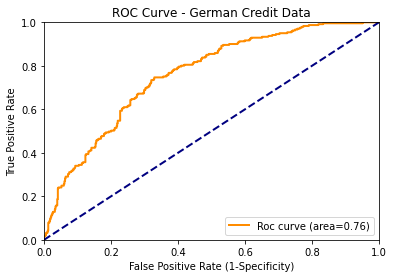

In [47]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc
fpr,tpr,thresholds=metrics.roc_curve(both['class'],both['Prob'],pos_label=1)
roc_auc=auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr,color='darkorange',lw=2,label='Roc curve (area=%0.2f)' %roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - German Credit Data')
plt.legend(loc='lower right')
plt.show()

Calculating accuracy using different threshold value

In [48]:
for i in list(np.arange(0,1,0.1)):
  both['y_pred']=0
  both.loc[both['Prob']>i,'y_pred']=1
  print('Threshold',i,'Train Accuracy:',round(metrics.accuracy_score(both['class'],both['y_pred']),4))

Threshold 0.0 Train Accuracy: 0.3012
Threshold 0.1 Train Accuracy: 0.4462
Threshold 0.2 Train Accuracy: 0.605
Threshold 0.30000000000000004 Train Accuracy: 0.6888
Threshold 0.4 Train Accuracy: 0.715
Threshold 0.5 Train Accuracy: 0.7375
Threshold 0.6000000000000001 Train Accuracy: 0.7412
Threshold 0.7000000000000001 Train Accuracy: 0.7125
Threshold 0.8 Train Accuracy: 0.7038
Threshold 0.9 Train Accuracy: 0.7012


Compairing threshold value to AUC area. Emphasize on AUC area rather than to accuracy because false hope is more dangerous .

In [63]:
for i in list(np.arange(.2,1,.04)):
  if i >.4:
    continue
  else:
    both['y_pred']=0
    both.loc[both['Prob']>i,'y_pred']=1
    print('Threshold value :',i)
    print('Train Confusion Matrix \n\n',pd.crosstab(both['y_pred'],both['class'],rownames=['Predicted'],colnames=['Actual']))
    print('Train Accuracy:',round(metrics.accuracy_score(both['class'],both['y_pred']),4))
    score=metrics.roc_auc_score(both['class'],both['y_pred'])
    print('AUC score:',score)
    print('\n')

Threshold value : 0.2
Train Confusion Matrix 

 Actual       0    1
Predicted          
0          278   35
1          281  206
Train Accuracy: 0.605
AUC score: 0.6760442105419429


Threshold value : 0.24000000000000002
Train Confusion Matrix 

 Actual       0    1
Predicted          
0          316   47
1          243  194
Train Accuracy: 0.6375
AUC score: 0.6851372115291829


Threshold value : 0.28
Train Confusion Matrix 

 Actual       0    1
Predicted          
0          354   59
1          205  182
Train Accuracy: 0.67
AUC score: 0.694230212516423


Threshold value : 0.32000000000000006
Train Confusion Matrix 

 Actual       0    1
Predicted          
0          380   64
1          179  177
Train Accuracy: 0.6962
AUC score: 0.707112582486509


Threshold value : 0.36000000000000004
Train Confusion Matrix 

 Actual       0    1
Predicted          
0          392   78
1          167  163
Train Accuracy: 0.6938
AUC score: 0.6888003919268997


Threshold value : 0.4
Train Confusion Mat

In [59]:
both['y_pred']=0
both.loc[both['Prob']>=.32,'y_pred']=1
print('Threshold value :',.35)
print('Train Confusion Matrix \n\n',pd.crosstab(both['y_pred'],both['class'],rownames=['Predicted'],colnames=['Actual']))
print('Train Accuracy:',round(metrics.accuracy_score(both['class'],both['y_pred']),4))
score=metrics.roc_auc_score(both['class'],both['y_pred'])
print(score)

Threshold value : 0.35
Train Confusion Matrix 

 Actual       0    1
Predicted          
0          380   64
1          179  177
Train Accuracy: 0.6962
0.707112582486509


In [60]:
y_pred_2=model_2.predict(sm.add_constant(x_test[col_list]))

In [61]:
testing=pd.DataFrame([y_test,y_pred_2]).T
testing.rename(columns={'Unnamed 0':'pred_prob'},inplace=True)
testing.reset_index(drop=True,inplace=True)
testing['prediction']=0
testing.loc[testing['pred_prob']>.35,'prediction']=1
print('Train Confusion Matrix \n\n',pd.crosstab(testing['prediction'],testing['class'],rownames=['Predicted'],colnames=['Actual']))
print('Test accuracy: ',metrics.accuracy_score(testing['class'],testing['prediction']))
print('AUC score: ',metrics.roc_auc_score(testing['class'],testing['prediction']))

Train Confusion Matrix 

 Actual     0.0  1.0
Predicted          
0          101   16
1           40   43
Test accuracy:  0.72
AUC score:  0.7225628080298112
